In [1]:
import pandas as pd
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import torch
from torch.nn.functional import softmax


In [6]:
!pip install transformers[sentencepiece]==4.10.0 datasets --quiet


     |████████████████████████████████| 2.8 MB 14.9 MB/s 
     |████████████████████████████████| 311 kB 75.3 MB/s 
     |████████████████████████████████| 67 kB 6.3 MB/s 
     |████████████████████████████████| 3.3 MB 59.5 MB/s 
     |████████████████████████████████| 596 kB 65.4 MB/s 
     |████████████████████████████████| 895 kB 67.4 MB/s 
     |████████████████████████████████| 1.1 MB 41.1 MB/s 
     |████████████████████████████████| 1.1 MB 60.7 MB/s 
     |████████████████████████████████| 133 kB 80.5 MB/s 
     |████████████████████████████████| 243 kB 79.9 MB/s 
     |████████████████████████████████| 271 kB 70.9 MB/s 
     |████████████████████████████████| 144 kB 74.0 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 


In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("Maha/OGBV-gender-bert-hi-en-trac2a")

model = AutoModelForSequenceClassification.from_pretrained("Maha/OGBV-gender-bert-hi-en-trac2a")

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/943 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/712M [00:00<?, ?B/s]

In [8]:
!pip install tqdm

In [9]:
from tqdm.notebook import tqdm, trange


In [10]:
tweet_df = pd.read_csv("/content/drive/MyDrive/data_1mill.csv", lineterminator='\n')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10,16,23,30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
subset_df = tweet_df[tweet_df['language'].isin(['hi','en','ta'])]
hin_df = subset_df[subset_df['language'] == 'hi']

In [12]:
hin_df.shape

(206068, 42)

In [13]:
hin_df.head()

,_id,tweet_id,tweet,image_url,s3_url,tweet_url,user_id,timestamp_of_creation,language,reply,repost,timestamp_of_scraping,type,search,content_type,conversation_id,date,geo,hashtags,likes_count,mentions,name,near,place,quote_url,replies_count,retweet_date,retweet_id,retweets_count,source,time,timezone,trans_dest,trans_src,translate,urls,user_rt,user_rt_id,username,video,date_created,time_created
7,619dbbadde83f8b60cc9ac4c,1331203624798539777,#SSRDeservesJustice #SushantSingRajput को कब ...,['https://pbs.twimg.com/media/EnliokyVgAEWtpx....,https://s3.ap-south-1.amazonaws.com/ogbv.tattl...,https://twitter.com/thenewsshots/status/133120...,1298619383388884997,2020-11-24 17:20:51 IST,hi,0,0,20211124094229,hashtag,#RheaChakraborty,image,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,619dbbadde83f8b60cc9ac4e,1331136365224886272,Sir aisa nahi bolte #RheaChakraborty k liye! A...,[],NaN,https://twitter.com/surabhi82707088/status/133...,1323921548281966593,2020-11-24 12:53:35 IST,hi,0,0,20211124094229,hashtag,#RheaChakraborty,text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,619dbbafde83f8b60cc9ac5a,1330202000970178561,"गांजा मजा भी देता है, सजा भी देता है। #BhartiS...",[],NaN,https://twitter.com/mesandeeppani/status/13302...,932504778067795970,2020-11-21 23:00:45 IST,hi,0,0,20211124094231,hashtag,#RheaChakraborty,text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,619dbbb1de83f8b60cc9ac60,1330161923753713671,सुशांत सिंह राजपूत के अकाउंट में हुई थी करोड़ो...,[],NaN,https://twitter.com/imssanger/status/133016192...,2695827330,2020-11-21 20:21:30 IST,hi,0,0,20211124094232,hashtag,#RheaChakraborty,text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,619dbbb1de83f8b60cc9ac61,1330161598783246336,सुशांत सिंह राजपूत के अकाउंट में हुई थी करोड़ो...,[],NaN,https://twitter.com/TV9Bharatvarsh/status/1330...,1039759933728645120,2020-11-21 20:20:13 IST,hi,0,0,20211124094233,hashtag,#RheaChakraborty,text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
hin_df=hin_df[['_id','tweet','language']]

In [15]:
hin_df.shape

(206068, 3)

In [16]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [17]:
tweets=hin_df["tweet"].tolist()

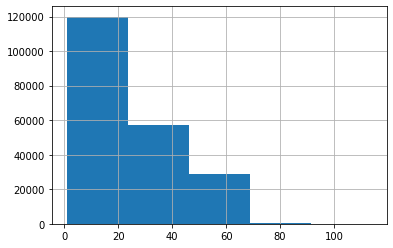

In [18]:
seq_len = [len(i.split()) for i in tweets]

pd.Series(seq_len).hist(bins = 5)

In [19]:
max(seq_len)

114

In [20]:
device = torch.device('cuda')
model.eval()
_ = model.to(device)

In [21]:
torch.cuda.empty_cache()

In [25]:
print('GPU memory: %.1f' % (torch.cuda.memory_allocated() // 1024 ** 2))

GPU memory: 760.0


In [26]:
label_map = {0: "None", 1: "Off/Hate"}

In [27]:
offense_list = []
offense_confidence = []
bs = 4
for x in trange(len(hin_df['tweet'])//bs):
    batch_x = list(hin_df['tweet'][x*bs:x*bs+bs])
    clean_x = [preprocess(tweet) for tweet in batch_x]
    encoded_input = tokenizer(clean_x, return_tensors='pt', padding=True, truncation=True, max_length=120)
    encoded_input.to(device)
    output = model(**encoded_input)
    out = softmax(output[0].data, dim=-1).detach().cpu()
    labels = [label_map[i] for i in torch.argmax(out,-1).numpy()]
    offense_list.extend(labels)
    for x_ind, y_ind in enumerate(torch.argmax(out,-1)):
        offense_confidence.append(round(out[x_ind, y_ind].item(),2))
    if(x%1000 == 0):
        print('GPU memory: %.1f' % (torch.cuda.memory_allocated() // 1024 ** 2))

  0%|          | 0/51517 [00:00<?, ?it/s]

GPU memory: 900.0
GPU memory: 1227.0
GPU memory: 1329.0
GPU memory: 1241.0
GPU memory: 1309.0
GPU memory: 1366.0
GPU memory: 1179.0
GPU memory: 1060.0
GPU memory: 1162.0
GPU memory: 915.0
GPU memory: 1115.0
GPU memory: 1391.0
GPU memory: 1267.0
GPU memory: 1297.0
GPU memory: 1180.0
GPU memory: 1366.0
GPU memory: 1327.0
GPU memory: 1139.0
GPU memory: 1381.0
GPU memory: 1092.0
GPU memory: 1228.0
GPU memory: 1313.0
GPU memory: 1381.0
GPU memory: 1375.0
GPU memory: 1340.0
GPU memory: 1190.0
GPU memory: 1385.0
GPU memory: 1242.0
GPU memory: 1374.0
GPU memory: 1145.0
GPU memory: 1109.0
GPU memory: 917.0
GPU memory: 1142.0
GPU memory: 1000.0
GPU memory: 1269.0
GPU memory: 864.0
GPU memory: 1341.0
GPU memory: 1013.0
GPU memory: 888.0
GPU memory: 919.0
GPU memory: 1126.0
GPU memory: 1375.0
GPU memory: 1038.0
GPU memory: 953.0
GPU memory: 1172.0
GPU memory: 1139.0
GPU memory: 1051.0
GPU memory: 973.0
GPU memory: 960.0
GPU memory: 1185.0
GPU memory: 1380.0
GPU memory: 820.0


In [28]:
len(offense_list)

206068

In [29]:
hin_df['bert-hi-trac2a-label'] = offense_list
hin_df['bert-hi-trac2a-confidence'] = offense_confidence

In [30]:
hin_df

,_id,tweet,language,bert-hi-trac2a-label,bert-hi-trac2a-confidence
7,619dbbadde83f8b60cc9ac4c,#SSRDeservesJustice #SushantSingRajput को कब ...,hi,None,0.76
9,619dbbadde83f8b60cc9ac4e,Sir aisa nahi bolte #RheaChakraborty k liye! A...,hi,None,0.91
21,619dbbafde83f8b60cc9ac5a,"गांजा मजा भी देता है, सजा भी देता है। #BhartiS...",hi,Off/Hate,0.59
27,619dbbb1de83f8b60cc9ac60,सुशांत सिंह राजपूत के अकाउंट में हुई थी करोड़ो...,hi,Off/Hate,0.52
28,619dbbb1de83f8b60cc9ac61,सुशांत सिंह राजपूत के अकाउंट में हुई थी करोड़ो...,hi,Off/Hate,0.52
...,...,...,...,...,...
1099649,61e14211e8241d3396cd45da,@MirzaSania बस इसको घटिया पाकिस्तानी सोच से बच...,hi,Off/Hate,0.82
1099702,61e1421329158668d17aa289,@sambhavnaseth @MercedesBenz Hey vivekbindra i...,hi,Off/Hate,0.60
1099710,61e142131cf48a3db760fbf0,@Nushrratt Lagta hai madam Kanewilliasom ko li...,hi,Off/Hate,0.70
1099895,61e14219d27c0a6f757ed657,@maithilithakur जब आदमी के 100 कर्म अच्छे होत...,hi,None,0.94


In [32]:
subset1_df = hin_df[hin_df['bert-hi-trac2a-label'].isin(['Off/Hate','None'])]
hate_hin_df = subset1_df[subset1_df['bert-hi-trac2a-label'] == 'Off/Hate']

In [33]:
hate_hin_df

,_id,tweet,language,bert-hi-trac2a-label,bert-hi-trac2a-confidence
21,619dbbafde83f8b60cc9ac5a,"गांजा मजा भी देता है, सजा भी देता है। #BhartiS...",hi,Off/Hate,0.59
27,619dbbb1de83f8b60cc9ac60,सुशांत सिंह राजपूत के अकाउंट में हुई थी करोड़ो...,hi,Off/Hate,0.52
28,619dbbb1de83f8b60cc9ac61,सुशांत सिंह राजपूत के अकाउंट में हुई थी करोड़ो...,hi,Off/Hate,0.52
33,619dbbb1de83f8b60cc9ac66,"@Bittu_Tufani इनको पकड़ो, तब मानें #SalmanKhan...",hi,Off/Hate,0.75
35,619dbbb1de83f8b60cc9ac68,Jab #RheaChakraborty chhut sakti hai toh Bhart...,hi,Off/Hate,0.84
...,...,...,...,...,...
1099437,61e1420c78928ade3ca7bbb6,@eyehinakhan Aap sab ko krte ho bas Mujhe chod...,hi,Off/Hate,0.67
1099444,61e1420ce8241d3396cd45b8,@MirzaSania Hindustan ki jaaan ki jaaan,hi,Off/Hate,0.85
1099649,61e14211e8241d3396cd45da,@MirzaSania बस इसको घटिया पाकिस्तानी सोच से बच...,hi,Off/Hate,0.82
1099702,61e1421329158668d17aa289,@sambhavnaseth @MercedesBenz Hey vivekbindra i...,hi,Off/Hate,0.60


In [38]:
df1 = hate_hin_df.sort_values('bert-hi-trac2a-confidence',ascending = False).head(50)


In [41]:
df1.to_csv('hin_Top_50_bert_trac2a' , index=False)